In [27]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [28]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

init = [1]

loc1_varying_factor = pandas.DataFrame(data={'com1_pur': init+[math.ceil(random.uniform(0, 0.75)*100)/100.0 for _ in range(_exec_scenarios-1)]})

loc6_varying_factor = pandas.DataFrame(data={'com1_pur': init+[math.ceil(random.uniform(0, 0.75)*100)/100.0 for _ in range(_exec_scenarios-1)]})

M = 1e6  # Big M

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

demand_factor = [1]*_exec_scenarios

In [29]:
list(loc1_varying_factor['com1_pur'])

[1.0, 0.03, 0.43, 0.38, 0.12, 0.1, 0.39, 0.27, 0.7, 0.35, 0.61, 0.05]

In [30]:
list(loc6_varying_factor['com1_pur'])

[1.0, 0.24, 0.67, 0.08, 0.31, 0.5, 0.57, 0.2, 0.01, 0.19, 0.52, 0.07]

In [31]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=150, block={'imp': 1, 'urg': 1}, price=0.00,
                    label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

com1 = Resource(name='com1', block={'imp': 1, 'urg': 1}, label='Commodity 1')
com1_stored10 = Resource(name='com1_stored10', store_max=10, label='Dummy variable for storage 10')
com1_stored20 = Resource(name='com1_stored20', store_max=20, label='Dummy variable for storage 20')
com1_stored50 = Resource(name='com1_stored50', store_max=50, label='Dummy variable for storage 50')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

# com2_pur = Resource(name='com2_pur', cons_max=200, block={'imp': 1, 'urg': 1}, price=50,
#                     label='Commodity 2 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
# 
# com2 = Resource(name='com2', block={'imp': 1, 'urg': 1}, label='Commodity 2')
# 
# com2_sold = Resource(name='com2_sold', revenue=80.00, demand=True, sell=True, label='Commodity 2 sold to outside the system')

In [32]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=M, conversion={com1_pur: -1, com1: 1}, capex=0, vopex=0, fopex=0,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1: -1, com1_sold: 1}, capex=0, vopex=0, fopex=0,
                  label='Sell com1')

com1_store10 = Process(name='com1_store10', conversion={com1:-1, com1_stored10:1}, store_max=10/_coms, prod_max=M, capex=100, vopex=1,
                  label="Storage capacity of 10 units")
com1_discharge10 = Process(name='com1_discharge10', conversion={com1_stored10:-1, com1:1}, 
                                 label='Discharge process from storage')

com1_store20 = Process(name='com1_store20', conversion={com1:-1, com1_stored20:1}, store_max=20/_coms, prod_max=M, capex=200, vopex=2,
                  label="Storage capacity of 20 units")
com1_discharge20 = Process(name='com1_discharge20', conversion={com1_stored20:-1, com1:1}, 
                                 label='Discharge process from storage')

com1_store50 = Process(name='com1_store50', conversion={com1:-1, com1_stored50:1}, store_max=50/_coms, prod_max=M, capex=500, vopex=5,
                  label="Storage capacity of 50 units")
com1_discharge50 = Process(name='com1_discharge50', conversion={com1_stored50:-1, com1:1}, 
                                 label='Discharge process from storage')

In [33]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_store20, com1_discharge20}, label="Location 1", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, availability_factor={com1_pur: loc1_varying_factor[['com1_pur']]})

loc2 = Location(name='loc2', processes={com1_store20, com1_discharge20}, label="Location 2", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_store20, com1_discharge50}, label="Location 3", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_store50, com1_discharge50}, label="Location 4", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_store50, com1_sell, com1_discharge50}, label="Location 5", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_store10, com1_discharge10}, label="Location 6", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1, availability_factor={com1_pur: loc6_varying_factor[['com1_pur']]})

loc7 = Location(name='loc7', processes={com1_store20, com1_discharge20}, label="Location 7", scales=scales, demand_scale_level=2,
                capacity_scale_level=1, availability_scale_level=1)

In [34]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================
truck20 = Transport(name='truck20', resources=[com1], trans_max=20, label='Truck with maximum capacity of 20 units', capex=20, vopex=0.02)
truck30 = Transport(name='truck30', resources=[com1], trans_max=30, label='Truck with maximum capacity of 30 units', capex=30, vopex=0.03)
truck40 = Transport(name='truck40', resources=[com1], trans_max=40, label='Truck with maximum capacity of 40 units', capex=40, vopex=0.04)
truck50 = Transport(name='truck50', resources=[com1], trans_max=50, label='Truck with maximum capacity of 50 units', capex=50, vopex=0.05)
truck100 = Transport(name='truck100', resources=[com1], trans_max=100, label='Truck with maximum capacity of 100 units', capex=100, vopex=0.1)

In [35]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50], [truck30], [], [], [], []],  # sink: location 1
    [[truck50], [], [], [truck50], [truck30], [], []],  # sink: location 2
    [[truck30], [], [], [truck20], [], [], []],  # sink: location 3
    [[], [truck50], [truck20], [], [truck100], [truck50], [truck40]],  # sink: location 4
    [[], [truck30], [], [truck100], [], [], [truck40]],  # sink: location 5
    [[], [], [], [truck50], [], [], []],  # sink: location 6
    [[], [], [], [truck40], [truck40], [], []]  # sink: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = list(locset)
sinks = list(locset)

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [36]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 125} if i == loc5 else {com1_sold: 0} for i in locset}
min_demand_satisfaction = 0.20
min_demand_dict = {i: {com1_sold: min_demand_satisfaction*100} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_disruption = Scenario(name='scenario_disruption', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='scenario_disruption')

In [37]:
problem_maxdischarge = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT,Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND, Constraints.NETWORK}, demand_sign='leq', objective_resource= com1_sold, objective=Objective.MAX_DISCHARGE)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand
constraint network cost
objective discharge max


In [38]:
results_maxdischarge = solve(scenario=scenario_disruption, instance=problem_maxdischarge, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 174772 rows, 253908 columns and 312001 nonzeros
Model fingerprint: 0x7903e707
Variable types: 253663 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+06]
Found heuristic solution: objective -0.0000000
Presolve removed 172432 rows and 247637 columns
Presolve time: 0.19s
Presolved: 2340 rows, 6271 columns, 11668 nonzeros
Variable types: 6271 continuous, 0 integer (0 binary)

Root relaxation: objective 2.720000e+04, 2486 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

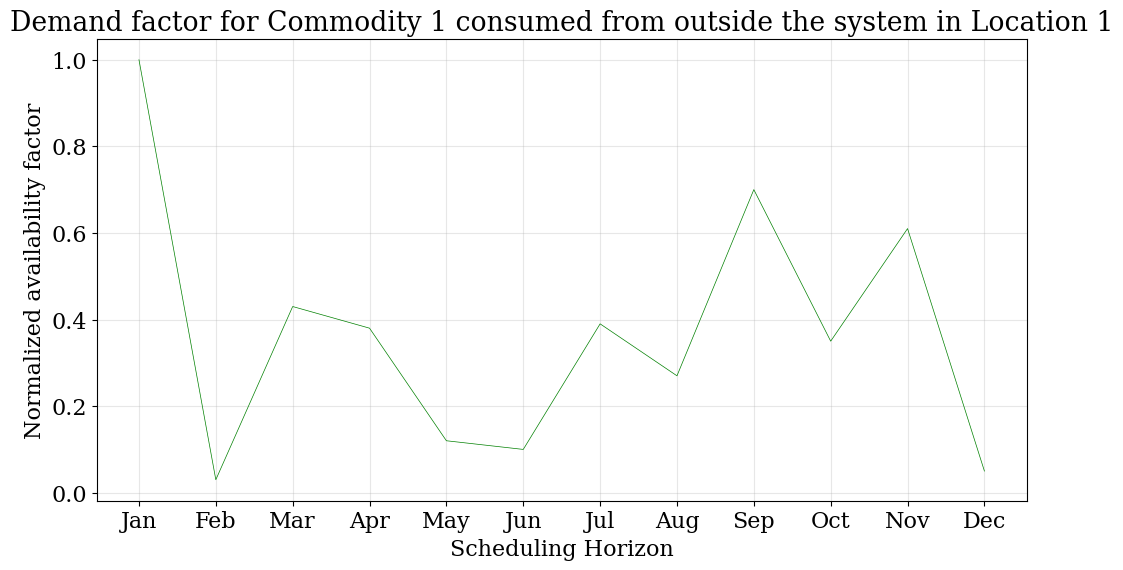

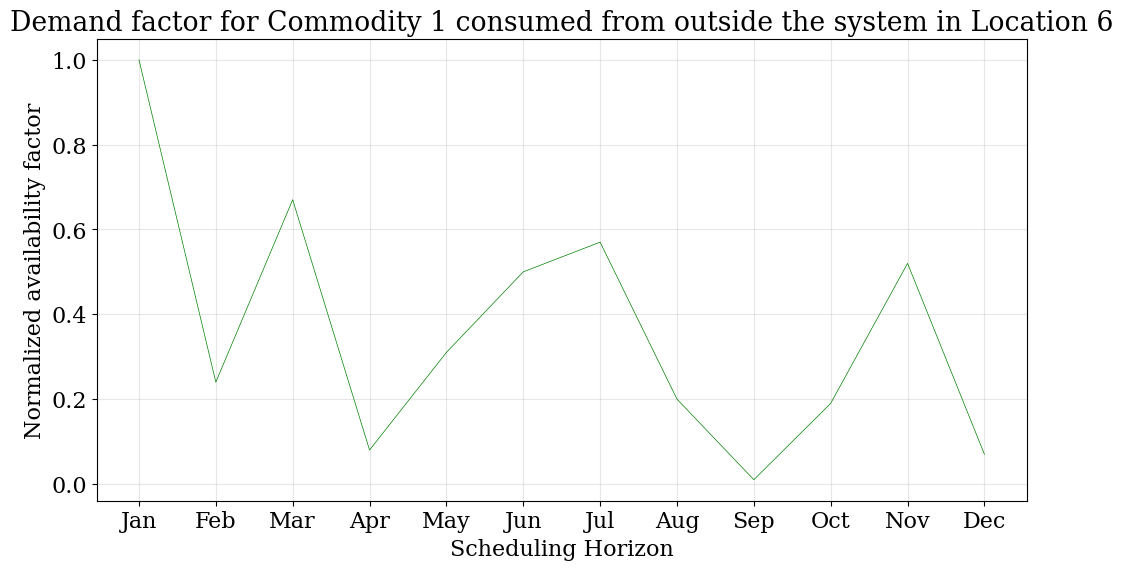

In [39]:
plot_scenario.availability_factor(scenario=scenario_disruption, resource=com1_pur, location=loc1, color='green')
plot_scenario.availability_factor(scenario=scenario_disruption, resource=com1_pur, location=loc6, color='green')

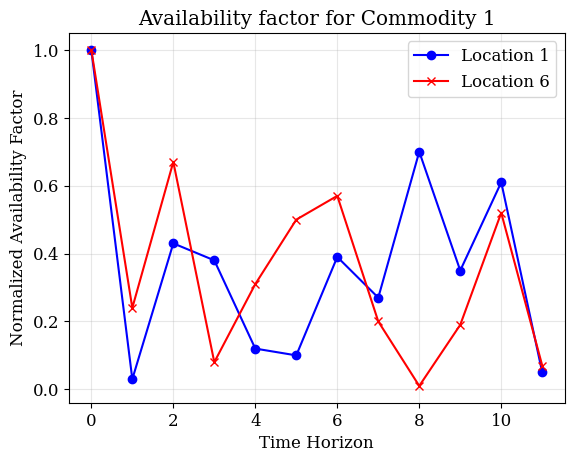

In [40]:

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(scenario_disruption.availability_factor['loc1']['com1_pur'])), list(scenario_disruption.availability_factor['loc1']['com1_pur'].values()), label='Location 1', color='blue', marker='o')

# Plot data from the second dataset
ax.plot(range(len(scenario_disruption.availability_factor['loc6']['com1_pur'])), list(scenario_disruption.availability_factor['loc6']['com1_pur'].values()), label='Location 6', color='red', marker='x')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Normalized Availability Factor')
ax.set_title('Availability factor for Commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

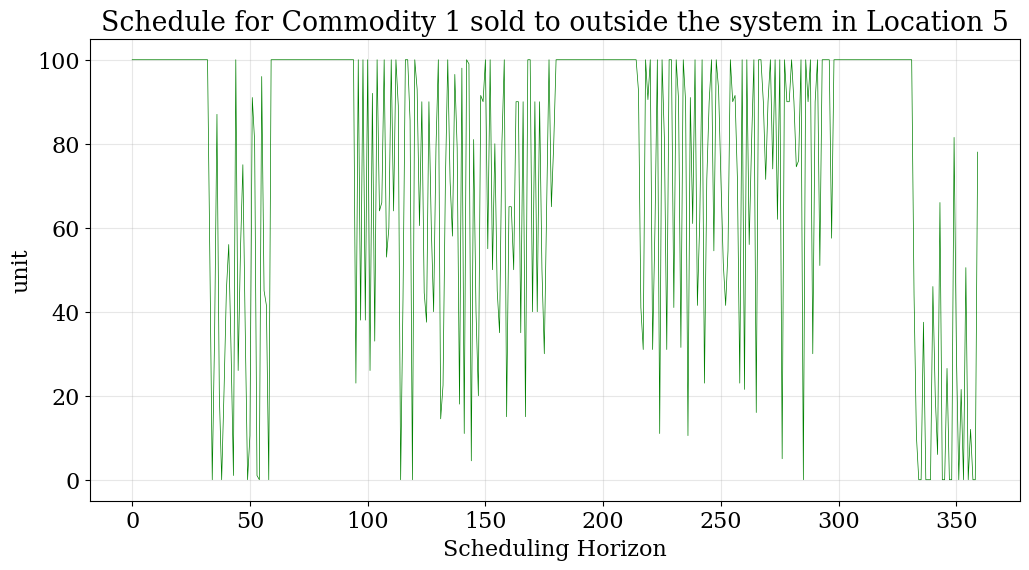

In [41]:
plot_results.schedule(results=results_maxdischarge, y_axis='S', component='com1_sold', location='loc5', color='green')

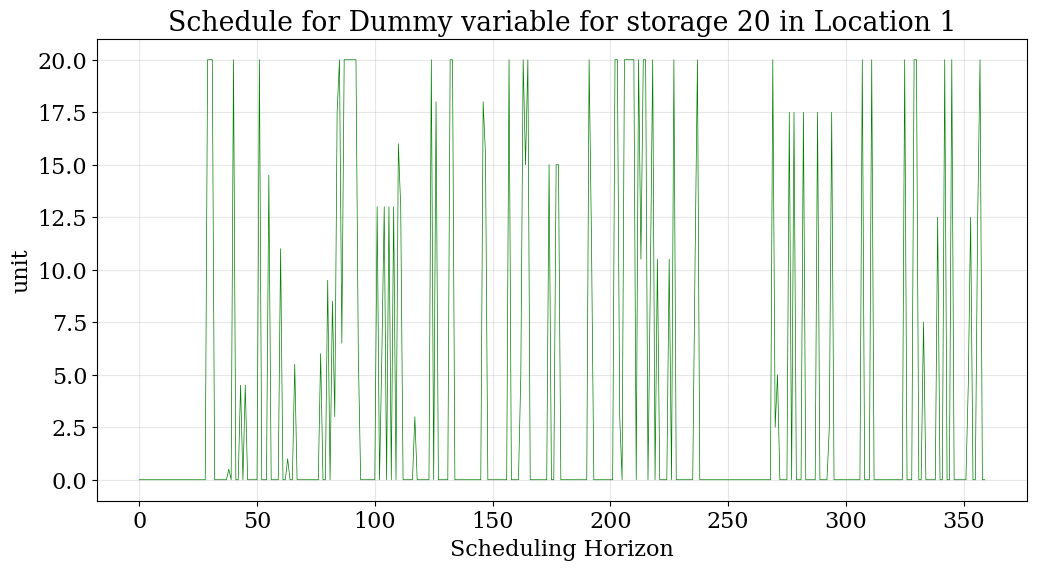

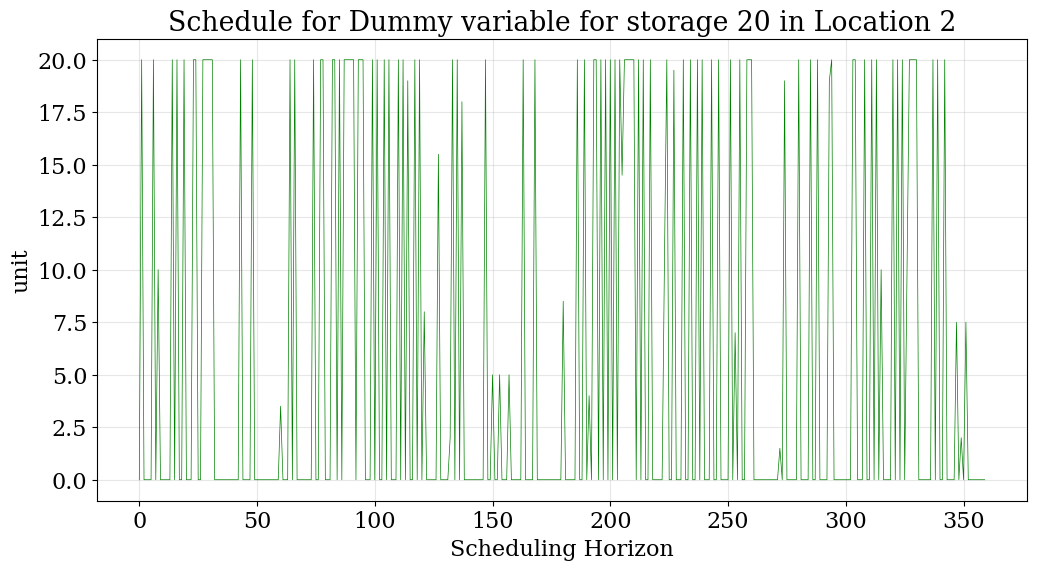

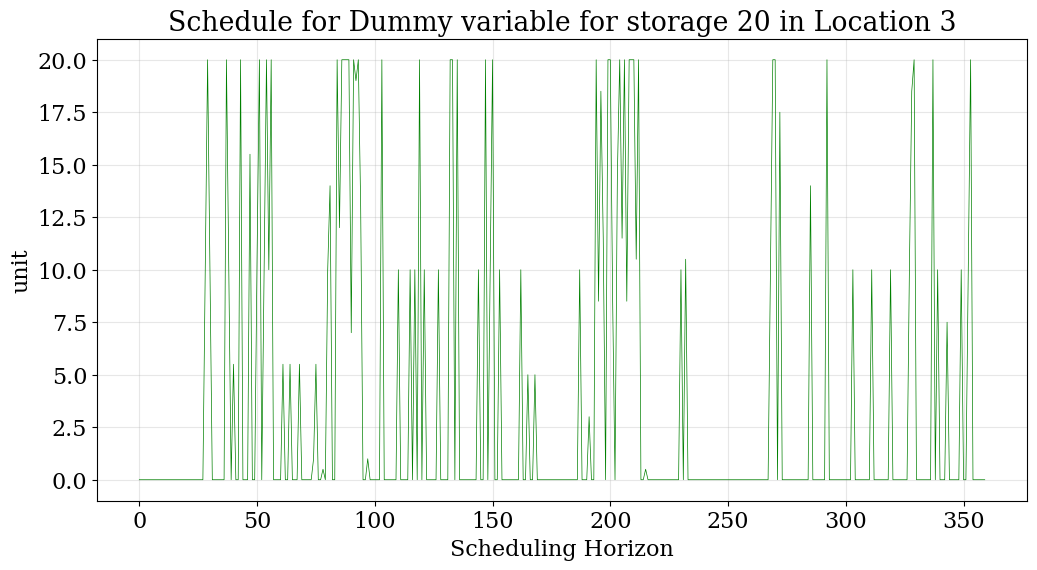

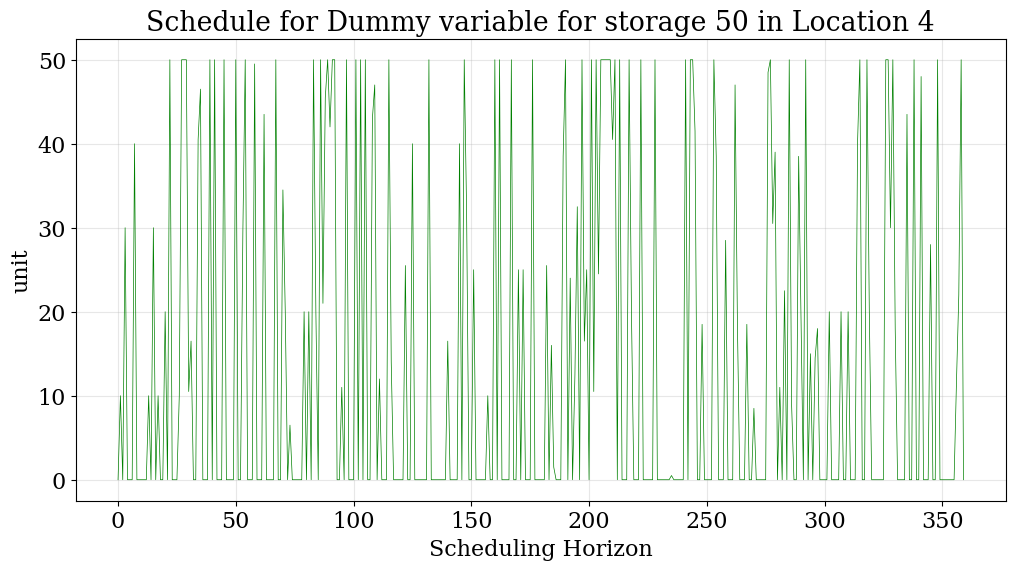

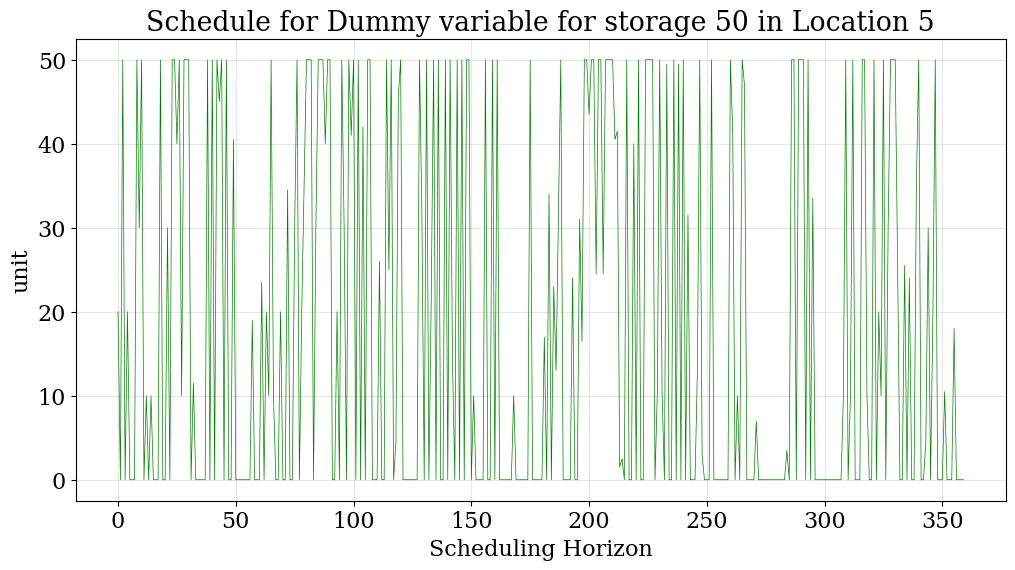

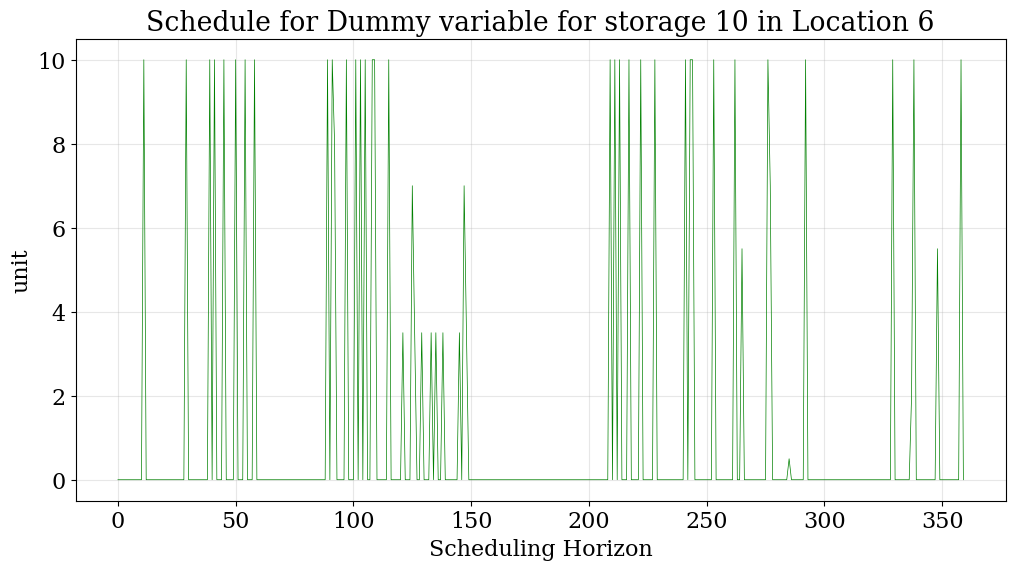

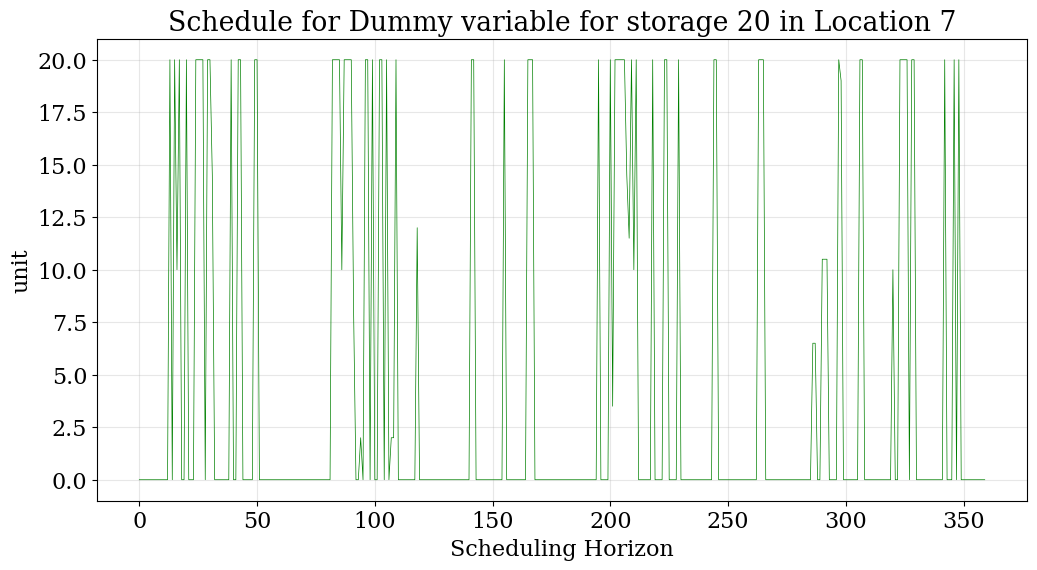

In [42]:
plot_results.schedule(results=results_maxdischarge, y_axis='Inv', component='com1_stored20', location='loc1', color='green')
plot_results.schedule(results=results_maxdischarge, y_axis='Inv', component='com1_stored20', location='loc2', color='green')
plot_results.schedule(results=results_maxdischarge, y_axis='Inv', component='com1_stored20', location='loc3', color='green')
plot_results.schedule(results=results_maxdischarge, y_axis='Inv', component='com1_stored50', location='loc4', color='green')
plot_results.schedule(results=results_maxdischarge, y_axis='Inv', component='com1_stored50', location='loc5', color='green')
plot_results.schedule(results=results_maxdischarge, y_axis='Inv', component='com1_stored10', location='loc6', color='green')
plot_results.schedule(results=results_maxdischarge, y_axis='Inv', component='com1_stored20', location='loc7', color='green')

In [43]:
min(value for key, value in results_maxdischarge.output['S'].items() if key[0]=='loc5')

0.0

In [44]:
problem_mincost = formulate(scenario=scenario_disruption, constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint production mode
constraint inventory balance
constraint resource export
constraint transport export
constraint export
constraint transport capacity UB
constraint transport capacity LB
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint demand penalty
objective cost w demand penalty


In [45]:
# min_demand = min_demand_dict
# if isinstance(min_demand, dict):
#     if isinstance(list(min_demand.keys())[0], Location):
#         try:
#             min_demand = {i.name: {
#                 j.name: min_demand[i][j] for j in min_demand[i].keys()} for i in min_demand.keys()}
#         except:
#             pass
# 
# problem_mincost.del_component(constraint_demand2)
# problem_mincost.constraint_demand2 = constraint_demand2(instance=problem_mincost, demand=min_demand, demand_factor=scenario_disruption.demand_factor, demand_scale_level=scenario_disruption.demand_scale_level, scheduling_scale_level=scenario_disruption.scheduling_scale_level, cluster_wt=None, loc_res_dict= None, sign='geq')

In [46]:
results_mincost = solve(scenario=scenario_disruption, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 174771 rows, 256428 columns and 314510 nonzeros
Model fingerprint: 0xbbae61b9
Variable types: 256183 continuous, 245 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+06]
Found heuristic solution: objective 4500000.0000
Presolve removed 160738 rows and 241299 columns
Presolve time: 0.21s
Presolved: 14033 rows, 15129 columns, 47123 nonzeros
Variable types: 15129 continuous, 0 integer (0 binary)

Root relaxation: objective 2.830856e+06, 16107 iterations, 1.26 seconds (1.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

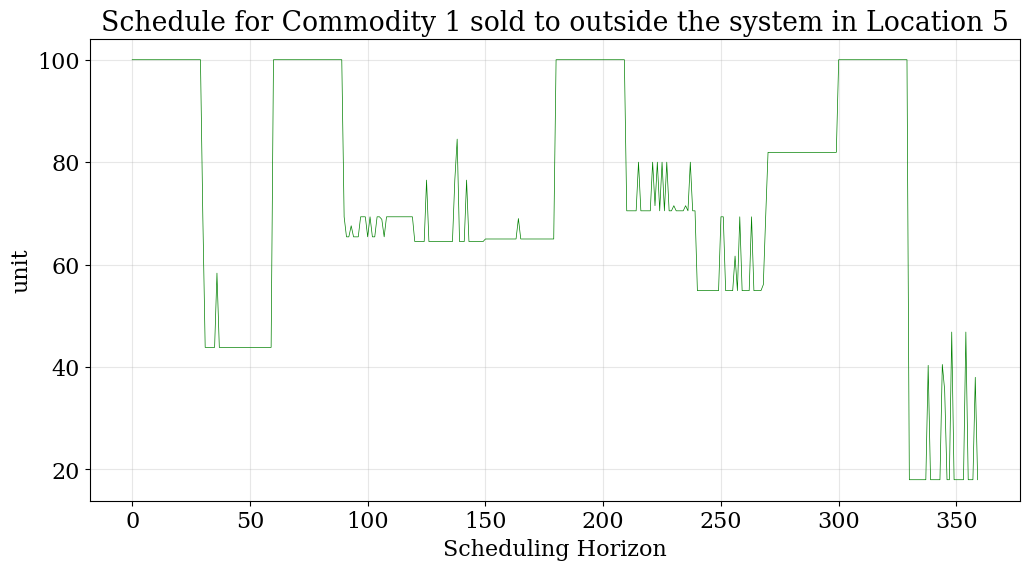

In [47]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

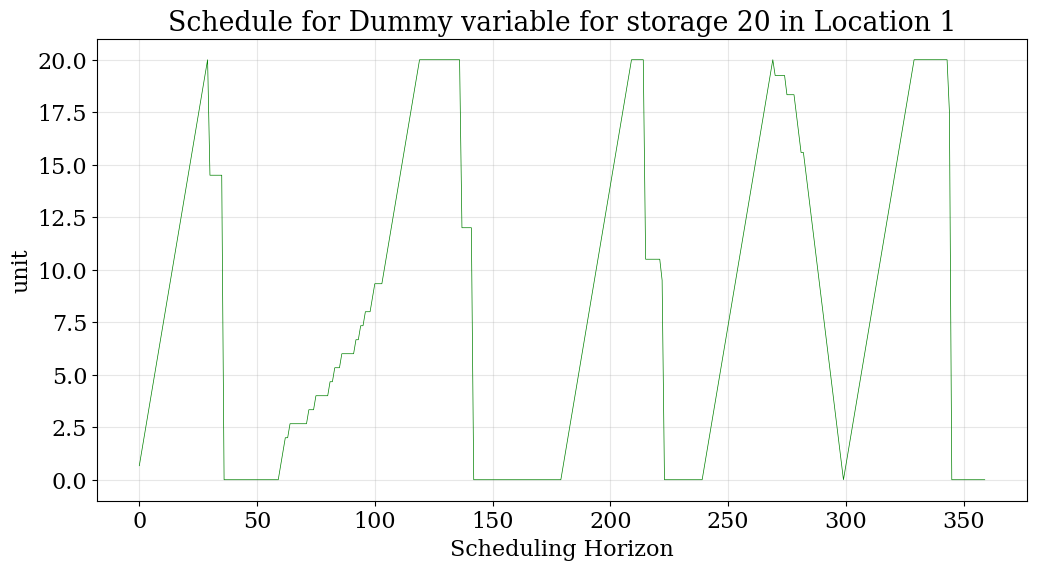

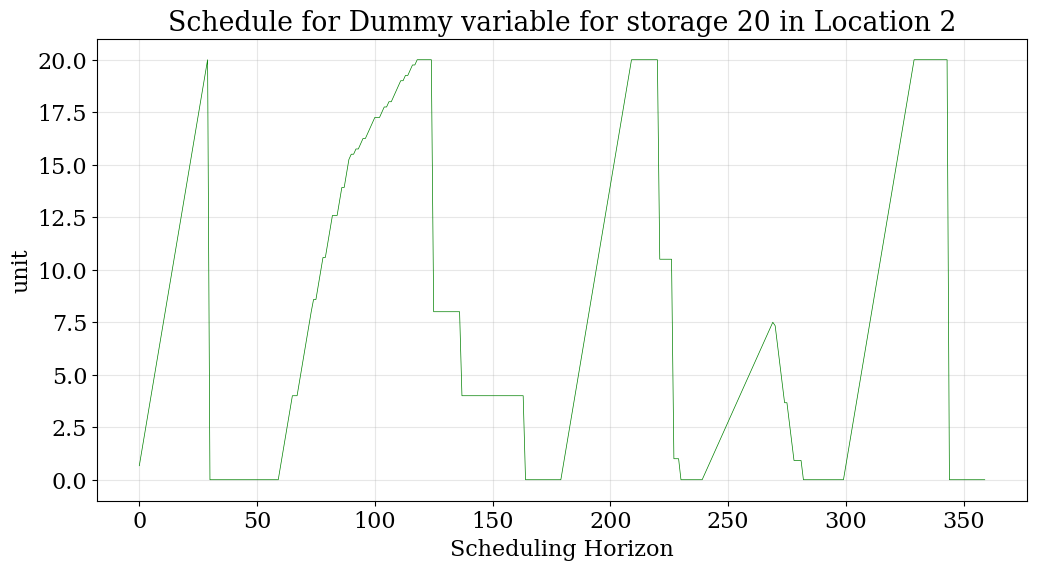

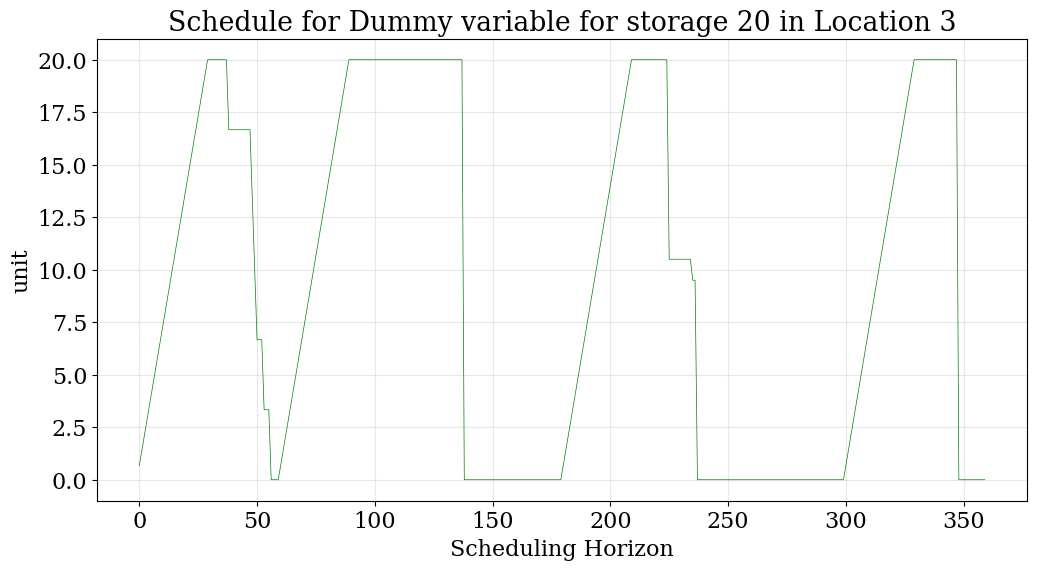

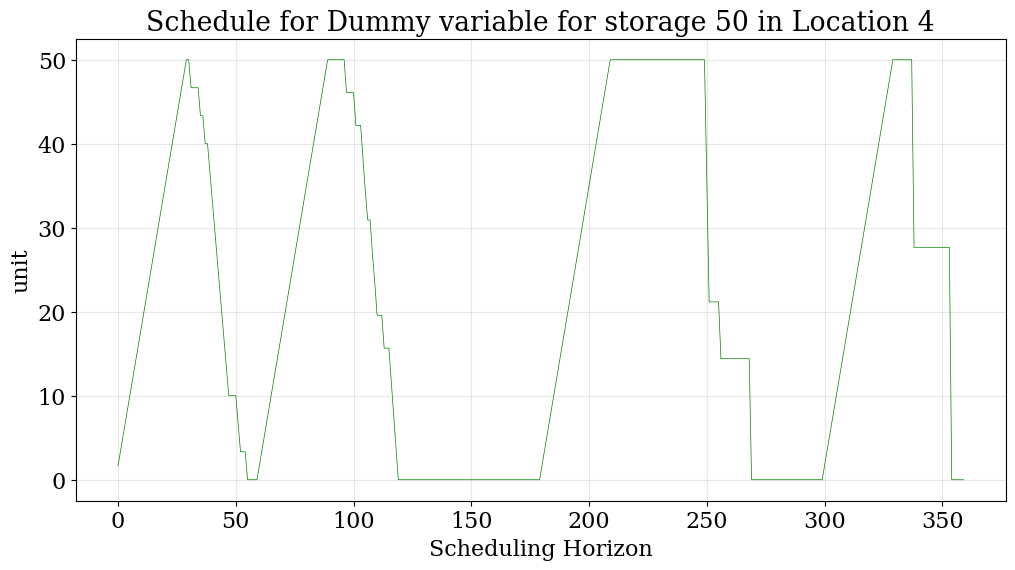

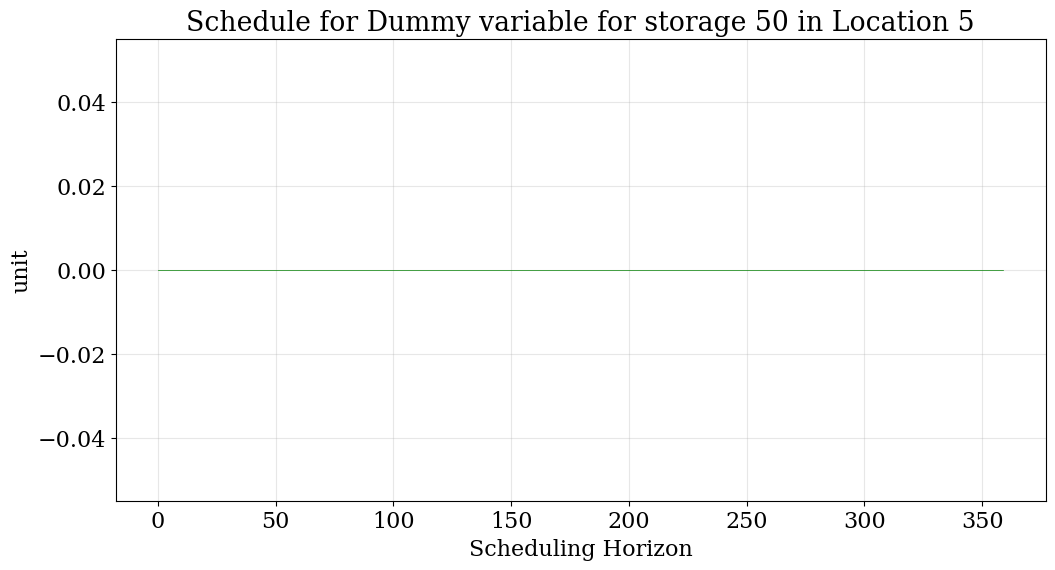

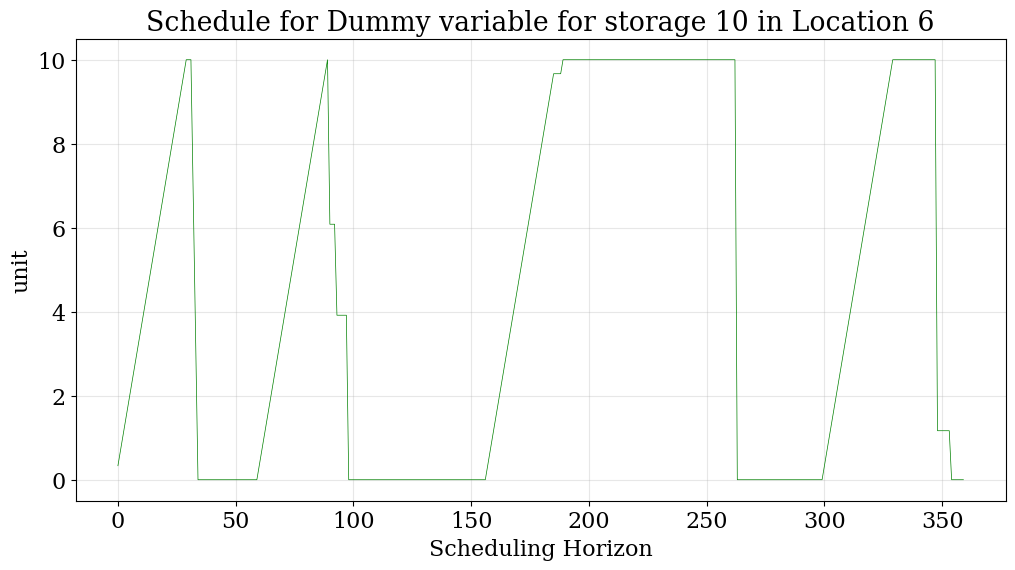

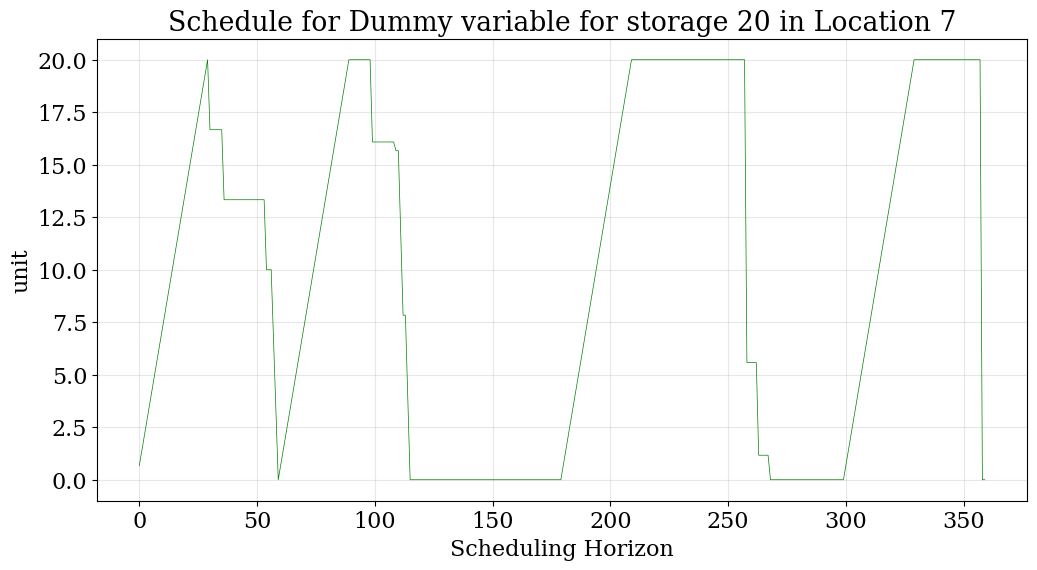

In [48]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored50', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored10', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_stored20', location='loc7', color='green')

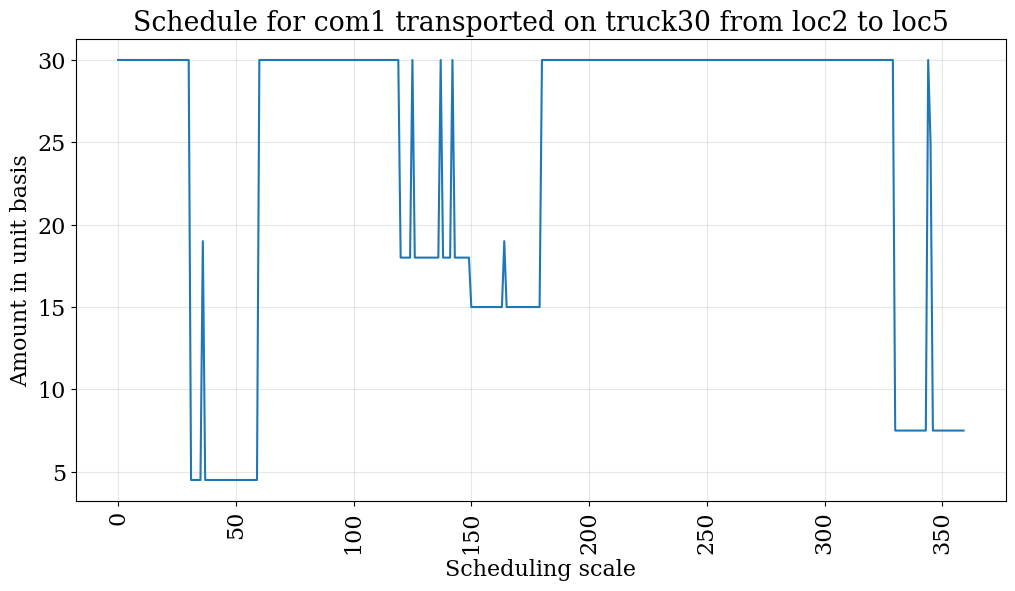

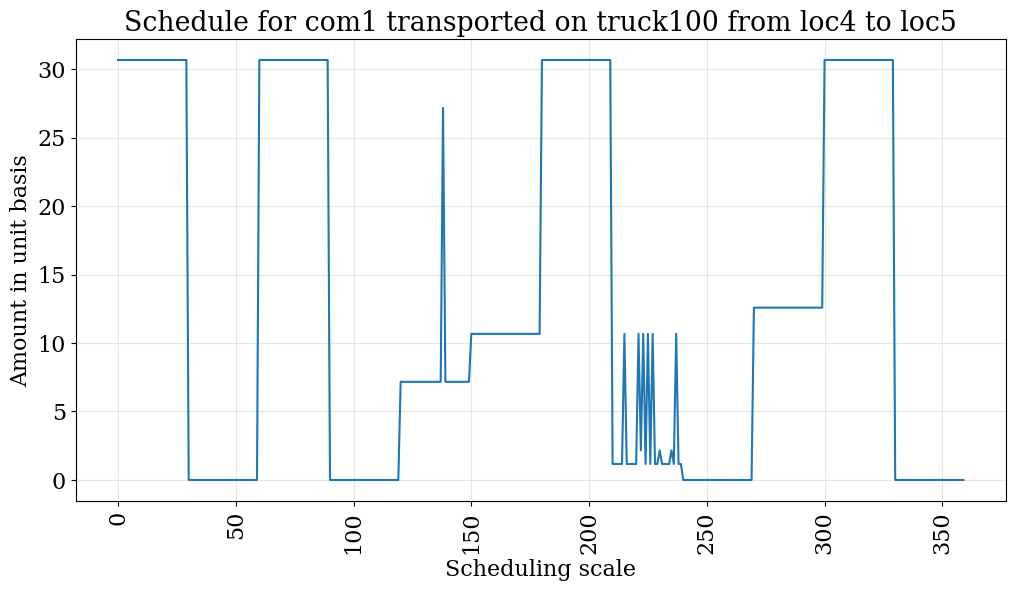

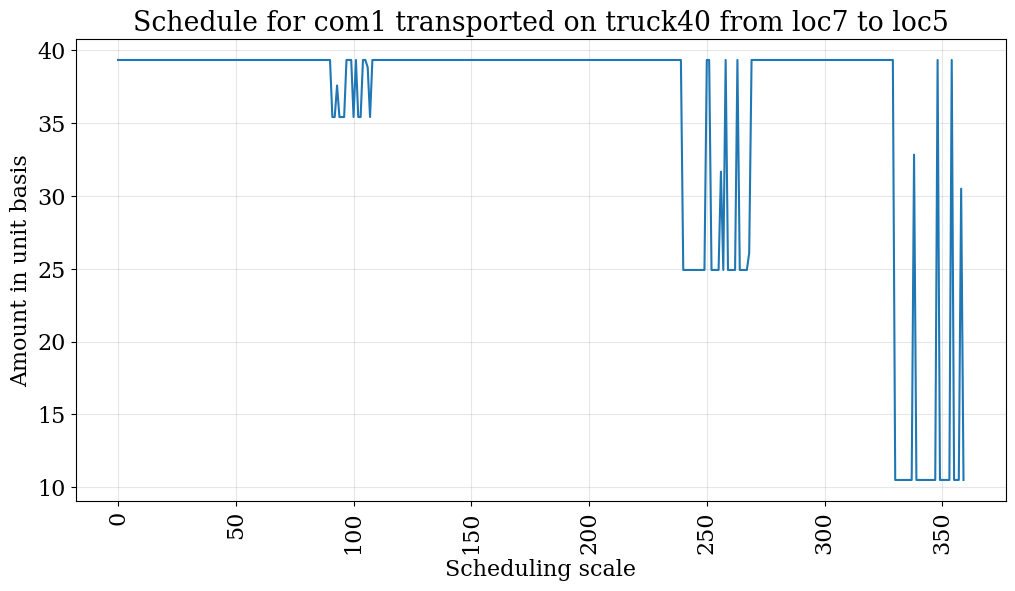

In [49]:
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30', resource='com1')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100', resource='com1')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40', resource='com1')

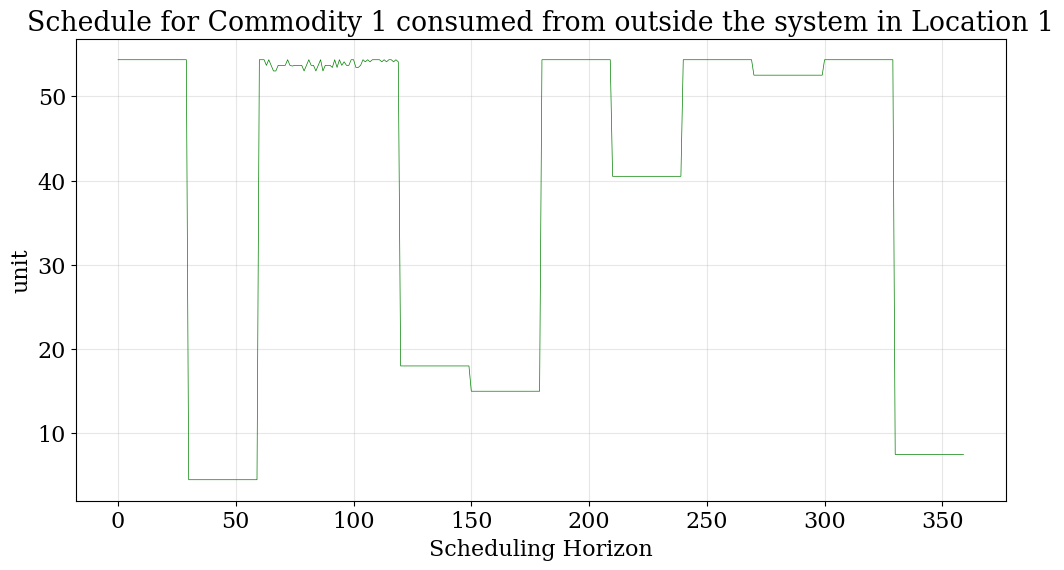

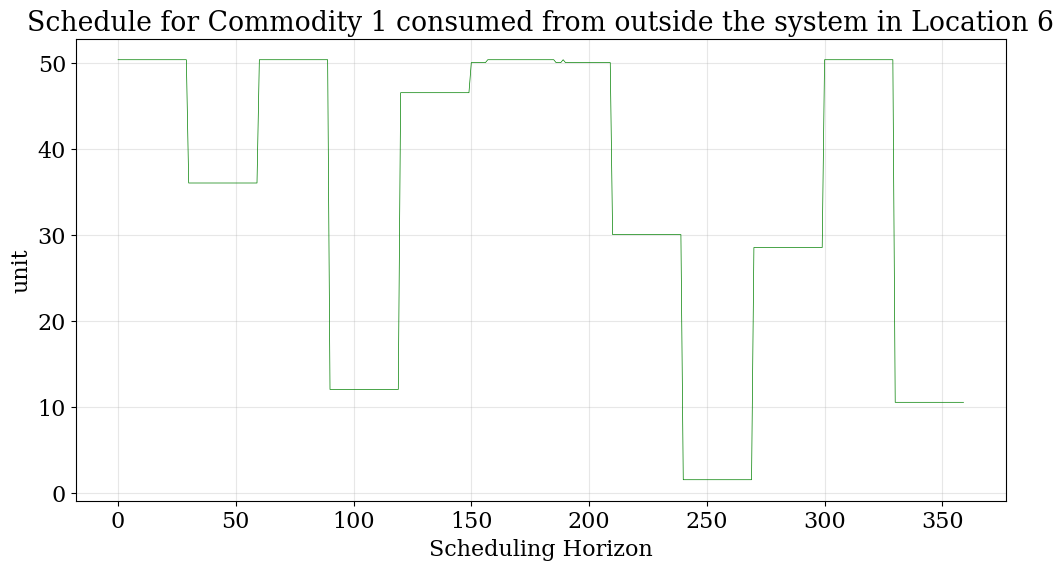

In [50]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')

In [51]:
print([(key, value) for key, value in results_mincost.output['C'].items() if key[0]=='loc1' and key[3]==2])

[(('loc1', 'com1_pur', 0, 2, 0), 54.33333333333209), (('loc1', 'com1_pur', 0, 2, 1), 54.333333333333385), (('loc1', 'com1_pur', 0, 2, 2), 54.333333333333385), (('loc1', 'com1_pur', 0, 2, 3), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 4), 54.333333333333385), (('loc1', 'com1_pur', 0, 2, 5), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 6), 52.9999999999998), (('loc1', 'com1_pur', 0, 2, 7), 52.9999999999998), (('loc1', 'com1_pur', 0, 2, 8), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 9), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 10), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 11), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 12), 54.333333333333385), (('loc1', 'com1_pur', 0, 2, 13), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 14), 53.583333333335716), (('loc1', 'com1_pur', 0, 2, 15), 53.666666666666465), (('loc1', 'com1_pur', 0, 2, 16), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 17), 53.66666666666672), (('loc1', 'com1_pur', 0, 2, 18), 53.66666666666672)

In [52]:
scenario_disruption.availability_factor['loc1']

{'com1_pur': {(0, 0): 1.0,
  (0, 1): 0.03,
  (0, 2): 0.43,
  (0, 3): 0.38,
  (0, 4): 0.12,
  (0, 5): 0.1,
  (0, 6): 0.39,
  (0, 7): 0.27,
  (0, 8): 0.7,
  (0, 9): 0.35,
  (0, 10): 0.61,
  (0, 11): 0.05}}